In [1]:
import os
import pandas as pd
import numpy as np
import numba
from numba import prange
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as  sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from utils import FeatureSelector, LabelEncoderWithThresh, TargetEncoderWithThresh

In [2]:
import pandas as pd
import numpy as np 
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

        
class TargetEncoderWithThresh(BaseEstimator, TransformerMixin):
    """
    A utlity class to help encode categorical variables using different methods.
    
    Inputs:
    cols: (List or str) Can be either a string or list of strings with column names
    targetcol: (str) Target column to encode column/group of columns with
    thresh: (int) Minimum count of grouping to encode (Acts as smoothing). Currently not implemented TODO
    func: (str or callable) Function to be applied on column/ group of columns to encode. 
          If str is provided, it should be a attribute of pandas Series
    cname: (str) Column name for new string
    func_kwargs: (dict) Additional arguments to be passed to function 
    add_to_orig: (bool) Whether to return dataframe with added feature or just the feature as series
    
    Output:
    pandas DataFrame/Series
    
    """
    def __init__(self, cols=None, targetcol=None, cname=None, thresh=0, func=np.mean,  add_to_orig=False,
                 func_kwargs={}, use_prior=False, alpha=0.5):                                                 
        self.cols = cols #Can be either a string or list of strings with column names
        self.targetcol = targetcol #Target column to encode column/group of columns with
        self.thresh = thresh  #Minimum count of grouping to encode (Acts as smoothing)
        self.func = func #Function to be applied on column/ group of columns to encode 
        self.add_to_orig = add_to_orig #Whether return a dataframe with added feature or just a series of feature
        self.cname = cname #Column to new feature generated
        self.func_kwargs = func_kwargs  #Additional key word arguments to be applied to func
        self.alpha = alpha #smoothing factor
        self.use_prior = use_prior
        
    #@numba.jit        
    def fit(self, X, y=None):
            
        if isinstance(self.func, str):
            if hasattr(pd.Series, self.func):
                #print("here")
                vals = getattr(X.groupby(self.cols)[self.targetcol], self.func)
                self.dictmap = vals(**self.func_kwargs)
                prior = getattr(X[self.targetcol], self.func)(**self.func_kwargs)
                
        else:
            self.dictmap = X.groupby(self.cols)[self.targetcol].apply(lambda x: self.func(x, **self.func_kwargs))
            prior = X[[self.targetcol]].apply(lambda x: self.func(x, **self.func_kwargs)).values[0]
        self.counts = Counter(zip(*[X[col].tolist() for col in self.cols]))
        if len(self.cols) == 1:
            counts_greater_than_thresh = [k[0] for k, v in self.counts.items() if v >= self.thresh ]
        else:
            counts_greater_than_thresh = [k for k, v in self.counts.items() if v >= self.thresh ]
        
        #print(self.dictmap.head())
        #print(self.counts.most_common(10))
        self.dictmap = self.dictmap.loc[self.dictmap.index.isin(counts_greater_than_thresh)]
        if self.use_prior:
            self.dictmap = {k: ((self.counts[k] * v + prior * self.alpha)/(self.counts[k] + self.alpha))
                            for k, v in self.dictmap.items()}
            self.dictmap = pd.Series(self.dictmap)
            self.dictmap.index.names = self.cols
        #print(self.dictmap.head())
        
        if self.cname:
            self.dictmap.name = self.cname
        else:
            cname = ''
            cname = [cname + '_' +str(col) for col in self.cols]
            self.cname = '_'.join(cname) + "_" + str(self.func)
            self.dictmap.name = self.cname
            
        #print(self.cname)
        #self.dictmap = self.dictmap
        return self
    
    #@numba.jit
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_transformed = X[self.cols]
            
            X_transformed = X_transformed.join(self.dictmap, on=self.cols, how='left')[self.cname]

            if self.add_to_orig:
                return pd.concat([X, X_transformed], axis=1, copy=False)
            else:
                return X_transformed.values

        else:
            raise TypeError("Input should be a pandas DataFrame")

In [3]:
def woe(X, y, cont=True):
    tmp = pd.DataFrame()
    tmp["variable"] = X
    if cont:
        tmp["variable"] = pd.qcut(tmp["variable"], 255, duplicates="drop")
    tmp["target"] = y
    var_counts = tmp.groupby("variable")["target"].count()
    var_events = tmp.groupby("variable")["target"].sum()
    var_nonevents = var_counts - var_events
    tmp["var_counts"] = tmp.variable.map(var_counts)
    tmp["var_events"] = tmp.variable.map(var_events)
    tmp["var_nonevents"] = tmp.variable.map(var_nonevents)
    events = sum(tmp["target"] == 1)
    nonevents = sum(tmp["target"] == 0)
    tmp["woe"] = np.log(((tmp["var_nonevents"])/nonevents)/((tmp["var_events"])/events))
    tmp["woe"] = tmp["woe"].replace(np.inf, 0).replace(-np.inf, 0)
    tmp["iv"] = (tmp["var_nonevents"]/nonevents - tmp["var_events"]/events) * tmp["woe"]
    iv = tmp.groupby("variable")["iv"].last().sum()
    return tmp["woe"], tmp["iv"], iv

In [4]:
import math
def entropy2(labels, base=None):
    """ Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = math.e if base is None else base
    for i in probs:
        ent -= i * math.log(i, base)

    return ent

In [5]:
@numba.jit
def get_splits(a):
    m = np.concatenate([[True], a[1:] != a[:-1], [True]])
    m = np.flatnonzero(m)
    return m


@numba.jit
def get_expanding_count(user, time, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    col: attribute col (product/webpage)
    '''
    out = np.zeros((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_out = np.zeros((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                for ii in range(pp):
                    col_out[j+oo[ii]:j+oo[ii+1]] = oo[ii] + 1
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            for ii in range(pp):
                out[j+oo[ii]:j+oo[ii+1]] = oo[ii] + 1
    return np.log1p(out)

In [6]:
@numba.jit
def get_prev_view(user, time, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    col: attribute col (product/webpage)
    '''
    out = -1*np.ones((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_out = -1*np.ones((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                if pp == 0:
                    col_out[j] = 0
                else:
                    for ii in range(1, pp):
                        col_out[j+oo[ii]:j+oo[ii+1]] = np.log1p(col_time[j+oo[ii]] - col_time[j+oo[ii-1]])
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            if pp == 0:
                out[j] = -1
            else:
                for ii in range(1, pp):
                    out[j+oo[ii]:j+oo[ii+1]] = np.log1p(time[j+oo[ii]] - time[j+oo[ii-1]])
    return out


@numba.jit
def get_next_view(user, time, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    col: attribute col (product/webpage)
    '''
    out = -1*np.ones((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_out = -1*np.ones((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                if pp == 0:
                    col_out[j] = 0
                else:
                    for ii in range(pp-1):
                        col_out[j+oo[ii]:j+oo[ii+1]] = np.log1p(col_time[j+oo[ii+1]] - col_time[j+oo[ii]])
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            if pp == 0:
                out[j] = -1
            else:
                for ii in range(pp-1):
                    out[j+oo[ii]:j+oo[ii+1]] = np.log1p(time[j +oo[ii+1]] - time[j+oo[ii]])
    return out

In [7]:
@numba.jit
def get_click_counts(user, time, click, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    click: Click column
    col: col (product/webpage)
    '''
    out = np.zeros((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_click = click[col_val_idx]
            col_out = np.zeros((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                cnt = 0
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                for ii in range(pp):
                    col_out[j+oo[ii]:j+oo[ii+1]] = cnt
                    cnt += np.sum(col_click[j+oo[ii]:j+oo[ii+1]])
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            cnt = 0
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            for ii in range(pp):
                out[j+oo[ii]:j+oo[ii+1]] = cnt
                cnt += np.sum(click[j+oo[ii]:j+oo[ii+1]])
    return np.log1p(out)

In [8]:
@numba.jit
def get_prev_click(user, time, click, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    click: Click column
    col: col (product/webpage)
    '''
    out = -1* np.ones((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_click = click[col_val_idx]
            col_out = -1 * np.ones((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                prev_time =-1
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                for ii in range(pp):
                    if prev_time != -1:
                        col_out[j+oo[ii]:j+oo[ii+1]] = np.log1p(col_time[j+oo[ii]] - prev_time)
                    if np.sum(col_click[j+oo[ii]:j+oo[ii+1]]) >= 1:
                        prev_time = col_time[j+oo[ii]] 
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            prev_time = -1
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            for ii in range(pp):
                if prev_time != -1:
                    out[j+oo[ii]:j+oo[ii+1]] = np.log1p(time[j+oo[ii]] - prev_time)
                if np.sum(click[j+oo[ii]:j+oo[ii+1]]) >= 1:
                    prev_time = time[j+oo[ii]]
    return out

In [9]:
##%%time
def get_view_feats(df):
    df = df.copy()
    users = df["user_id"].values
    times = df["DateTime"].astype(int).values/10**12
    products = df["product"].values
    webpages = df["webpage_id"].values
    campaigns = df["campaign_id"].values
    df["prev_view"] = get_prev_view(users, times)
    
    print("Getting previous product view")
    df["prev_prod_view"] = get_prev_view(users, times, products)
    df["prev_wp_view"] = get_prev_view(users, times, webpages)
    
    print("Getting previous campaign view")
    df["prev_camp_view"] = get_prev_view(users, times, campaigns)
    df["next_view"] = get_next_view(users, times)
    df["next_prod_view"] = get_next_view(users, times, products)
    df["next_wp_view"] = get_next_view(users, times, webpages)
    df["next_camp_view"] = get_next_view(users, times, campaigns)    
    return df

In [10]:
def get_count_feats(df):
    df = df.copy()
    uids = df["user_id"].values
    times = df["DateTime"].values
    products = df["product"].values
    wpids = df["webpage_id"].values
    cat1 = df["product_category_1"].values
    cat2 = df["product_category_2"].values
    df["view_counts"] = get_expanding_count(uids, times)
    df["prod_view_counts"] = get_expanding_count(uids, times, products)
    df["wp_view_counts"] = get_expanding_count(uids, times, wpids)
    df["cat1_view_counts"] = get_expanding_count(uids, times, cat1)
    df["cat2_view_counts"] = get_expanding_count(uids, times, cat2)
    return df

In [11]:
def get_click_feats(tr, val):
    tr = tr.copy()
    uids = tr["user_id"].values
    products = tr["product"].values
    wpids = tr["webpage_id"].values
    datetime = tr["DateTime"].astype(int).values/10**12
    clicks = tr["is_click"].values
    
    tr["prev_click"] = get_prev_click(uids, datetime, clicks)
    tr["prev_prod_click"] = get_prev_click(uids, datetime, clicks, products)
    tr["prev_wp_click"] = get_prev_click(uids, datetime, clicks, wpids)
    
    tr["click_counts"] = get_click_counts(uids, datetime, clicks)
    tr["prod_click_counts"] = get_click_counts(uids, datetime, clicks, products)
    tr["wp_click_counts"] = get_click_counts(uids, datetime, clicks, wpids)
    
    tr_clicks = tr.loc[tr.is_click == 1].groupby("user_id")["DateTime"].max()
    val["prev_click_time"] = val.user_id.map(tr_clicks)
    val["prev_click"] = np.log1p((val["DateTime"] - val["prev_click_time"]).astype(int)/10**12)
    val["prev_click"] = val["prev_click"].fillna(-1)
    del val["prev_click_time"]
    
    tr_clicks = tr.loc[tr.is_click == 1].groupby(["user_id", "product"])["DateTime"].max()
    tr_clicks.name = "prev_prod_click_time"
    val = val.join(tr_clicks, on=["user_id", "product"], how="left")
    val["prev_prod_click"] = np.log1p((val["DateTime"] - val["prev_prod_click_time"]).astype(int)/10**12)
    val["prev_prod_click"] = val["prev_prod_click"].fillna(-1)
    del val["prev_prod_click_time"]
                   
    tr_clicks = tr.loc[tr.is_click == 1].groupby(["user_id", "product"])["DateTime"].max()
    tr_clicks.name = "prev_wp_click_time"
    val = val.join(tr_clicks, on=["user_id", "product"], how="left")
    val["prev_wp_click"] = np.log1p((val["DateTime"] - val["prev_wp_click_time"]).astype(int)/10**12)
    val["prev_wp_click"] = val["prev_wp_click"].fillna(-1)
    del val["prev_wp_click_time"]
    
    val["click_counts"] = val["user_id"].map(np.log1p(tr.groupby("user_id")["is_click"].sum())).fillna(0)
    
    tmp = np.log1p(tr.groupby(["user_id", "product"])["is_click"].sum())
    tmp.name = "prod_click_counts"
    val = val.join(tmp, on=["user_id", "product"], how="left").fillna(0)
    
    tmp = np.log1p(tr.groupby(["user_id", "webpage_id"])["is_click"].sum())
    tmp.name = "wp_click_counts"
    val = val.join(tmp, on=["user_id", "webpage_id"], how="left").fillna(0)
    
    
    return tr, val

In [12]:
#Read data
train = pd.read_csv("data/train.csv", parse_dates=["DateTime"])
test = pd.read_csv("data/test.csv", parse_dates=["DateTime"])

train["flag1"] = "train"
test["flag1"] = "test"
test["is_click"] = 0

data_all = pd.concat([train, test], axis=0).reset_index()
print(train.shape, test.shape, data_all.shape)

(463291, 16) (128858, 16) (592149, 17)


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [13]:
tmp = train.loc[train.user_id == 474804]
users = tmp.user_id.values
times = tmp.DateTime.astype(int).values
products = tmp["product"].values
tmp.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,flag1
58887,500591,2017-07-02 18:26:00,474804,H,405490,60305,3,NaN,1.0,Male,1.0,3.0,NaN,0,0,train
59174,281620,2017-07-02 18:29:00,474804,D,98970,6970,4,NaN,1.0,Male,1.0,3.0,NaN,0,0,train
59175,93852,2017-07-02 18:29:00,474804,C,405490,60305,3,NaN,1.0,Male,1.0,3.0,NaN,0,0,train
59642,214839,2017-07-02 18:35:00,474804,I,414149,45962,3,NaN,1.0,Male,1.0,3.0,NaN,0,0,train
59643,531482,2017-07-02 18:35:00,474804,E,98970,6970,2,NaN,1.0,Male,1.0,3.0,NaN,0,0,train


In [14]:
%%time
get_expanding_count(users, times, products)

CPU times: user 946 ms, sys: 14.4 ms, total: 960 ms
Wall time: 973 ms


array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       1.09861229, 0.69314718, 1.09861229, 1.09861229, 1.38629436,
       1.38629436, 1.60943791, 1.60943791, 1.09861229, 1.09861229,
       1.60943791, 1.38629436, 1.09861229, 0.69314718, 1.38629436,
       1.60943791, 1.60943791, 0.69314718, 1.79175947, 1.94591015,
       1.38629436, 1.60943791, 1.79175947, 1.38629436, 2.07944154,
       1.94591015, 1.09861229, 2.07944154, 2.19722458, 1.09861229,
       2.19722458, 2.30258509, 1.94591015, 1.60943791, 2.39789527,
       1.60943791, 1.38629436, 1.94591015, 2.07944154, 2.48490665,
       2.19722458, 2.56494936, 1.79175947, 2.30258509, 2.39789527,
       2.07944154, 1.79175947, 1.60943791, 2.19722458, 1.94591015,
       2.63905733, 2.30258509, 1.94591015, 2.07944154, 1.38629436,
       2.48490665, 1.79175947, 2.39789527, 2.48490665, 2.19722458,
       2.56494936, 2.07944154, 2.56494936, 2.30258509, 2.63905733,
       2.39789527, 2.63905733, 2.77258872, 1.94591015, 2.63905

In [15]:
%%time
get_prev_view(users, times)
get_next_view(users, times)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


In [16]:
#%%time
clicks = tmp.is_click.values
get_click_counts(users, times, clicks)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
get_prev_click(users, times, clicks, products)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [18]:
prod_map = {"H": 0, "B": 1, "D": 2, "A": 3, "C": 4, "G": 5,
            "F": 6, "I": 7, "E": 8, "J": 9}
train["product"] = train["product"].map(prod_map)
data_all["product"] = data_all["product"].map(prod_map)

In [19]:
#Label encode object types
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
for col in ["gender", "campaign_id", "webpage_id", "product_category_2"]:
    data_all[col] = lbl.fit_transform(data_all[col].astype(str))
    train[col] = lbl.transform(train[col].astype(str))
    test[col] = lbl.transform(test[col].astype(str))

In [20]:
train.sort_values(by=["user_id", "DateTime"], inplace=True)
data_all.sort_values(by=["user_id", "DateTime"], inplace=True)

In [21]:
%%time
train = get_view_feats(train)
data_all = get_view_feats(data_all)

Getting previous product view
Getting previous campaign view
Getting previous product view
Getting previous campaign view
CPU times: user 53.1 s, sys: 495 ms, total: 53.6 s
Wall time: 52.4 s


In [22]:
%%time
train = get_count_feats(train)
data_all = get_count_feats(data_all)

CPU times: user 31.7 s, sys: 364 ms, total: 32.1 s
Wall time: 31.4 s


In [23]:
hist_data_agg = pd.read_csv("data/hist_data_agg.csv")
train = pd.merge(train, hist_data_agg, on=["user_id", "product"], how="left")
data_all = pd.merge(data_all, hist_data_agg, on=["user_id", "product"], how="left")

In [24]:
train["hour"] = train["DateTime"].dt.hour
train["dayofweek"] = train["DateTime"].dt.dayofweek

data_all["hour"] = data_all["DateTime"].dt.hour
data_all["dayofweek"] = data_all["DateTime"].dt.dayofweek

In [25]:
agg4 = pd.read_csv("data/agg4.csv")
agg5 = pd.read_csv("data/agg5.csv")
#agg4.head(), agg5.head()

In [26]:
train = pd.merge(train, agg4, on=["user_id", "dayofweek"], how="left")
data_all = pd.merge(data_all, agg4, on=["user_id", "dayofweek"], how="left")

In [27]:
train["usr_dayofweek_clickratio"] = train["usr_dayofweek_cnt"]/train["total_adclicks"]
data_all["usr_dayofweek_clickratio"] = data_all["usr_dayofweek_cnt"]/data_all["total_adclicks"]

In [28]:
train = pd.merge(train, agg5, on=["user_id", "hour"], how="left")
data_all = pd.merge(data_all, agg5, on=["user_id", "hour"], how="left")

train["usr_hourofday_clickratio"] = train["usr_hour_cnt"]/train["total_adclicks"]
data_all["usr_hourofday_clickratio"] = data_all["usr_hour_cnt"]/data_all["total_adclicks"]

In [29]:
nmf_feats = pd.read_csv("data/nmf_feats.csv")
train =  pd.merge(train, nmf_feats, on=["user_id"], how="left")
data_all =  pd.merge(data_all, nmf_feats, on=["user_id"], how="left")

In [30]:
nmf_day_feats = pd.read_csv("data/nmf_day_feats.csv")
train =  pd.merge(train, nmf_day_feats, on=["user_id"], how="left")
data_all =  pd.merge(data_all, nmf_day_feats, on=["user_id"], how="left")

In [31]:
user_time_counts = pd.read_csv("data/user_time_counts.csv")
train =  pd.merge(train, user_time_counts, on=["user_id"], how="left")
data_all =  pd.merge(data_all, user_time_counts, on=["user_id"], how="left")

In [32]:
cols = user_time_counts.columns
cols = [col for col in cols if col != "user_id"]
train[cols].fillna(0)
data_all[cols].fillna(0)

,Unnamed: 0,user_time_counts_mean,user_time_counts_std,user_time_counts_max,user_time_counts_median,user_time_counts_skew
0,0.0,1.000000,0.000000,1.0,1.0,0.000000
1,0.0,1.000000,0.000000,1.0,1.0,0.000000
2,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,1.0,1.714286,1.084093,7.0,1.0,2.180657
4,1.0,1.714286,1.084093,7.0,1.0,2.180657
5,1.0,1.714286,1.084093,7.0,1.0,2.180657
6,2.0,1.634146,0.829340,4.0,1.0,1.069117
7,2.0,1.634146,0.829340,4.0,1.0,1.069117
8,3.0,1.444444,0.808683,4.0,1.0,1.734458
9,4.0,1.469388,0.793254,4.0,1.0,1.540376


In [33]:
def get_overall_count_feats(df):
    df = df.copy()
    enc = TargetEncoderWithThresh(cols=["user_id"], targetcol="is_click", func='count')
    df["all_counts"] = np.log1p(enc.fit_transform(df))
    
    enc = TargetEncoderWithThresh(cols=["product"], targetcol="is_click", func='count')
    df["prd_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["webpage_id"], targetcol="is_click", func='count')
    df["wp_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "product"], targetcol="is_click", func='count')
    df["all_usr_prd_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "webpage_id"], targetcol="is_click", func='count')
    df["all_usr_wp_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_group_id", "campaign_id"], targetcol="is_click", func='count')
    df["all_grp_camp_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "product", "webpage_id"], targetcol="is_click", func='count')
    df["all_usr_prd_wp_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["product", "webpage_id"], targetcol="is_click", func='count')
    df["all_prd_wp_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "DateTime"], targetcol="is_click", func='count')
    df["usr_date_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "webpage_id", "DateTime"], targetcol="is_click", func='count')
    df["usr_wp_date_counts"] = np.log1p(enc.fit_transform(df))
    
    enc = TargetEncoderWithThresh(cols=["user_id", "DateTime"], targetcol="product", func='nunique')
    df["usr_date_nunq_prods"] = enc.fit_transform(df)
    return df

In [34]:
train = get_overall_count_feats(train)
data_all = get_overall_count_feats(data_all)

In [55]:
def get_target_encoding(tr, val, y_tr):
    cvlist2 = list(StratifiedKFold(10, shuffle=True, random_state=12345786).split(tr, y_tr))
    print("Likelihhod encoding product webpage_id")
    enc = TargetEncoderWithThresh(cols=["product", "webpage_id"], targetcol="is_click", use_prior=True, func='mean')
    tr["prod_wp_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["prod_wp_tmean"] = enc.fit(tr).transform(val)
    
    print("Likelihhod encoding product webpage_id")
    enc = TargetEncoderWithThresh(cols=["product", "webpage_id"], targetcol="user_id", use_prior=True, func=entropy2)
    tr["prod_wp_entropy"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["prod_wp_entropy"] = enc.fit(tr).transform(val)
    
    print("Likelihhod encoding user id")
    enc = TargetEncoderWithThresh(cols=["user_id"], targetcol="is_click", use_prior=True, func='mean', alpha=0.5)
    tr["usr_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["usr_tmean"] = enc.fit(tr).transform(val)

    #print("Likelihhod encoding product category 1 and 2")
    #enc = TargetEncoderWithThresh(cols=["product_category_1", "product_category_2"], targetcol="is_click", func=entropy2, use_prior=True, alpha=1)
    #tr["cat1_cat2_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    #val["cat1_cat2_tmean"] = enc.fit(tr).transform(val)
    
    print("Likelihhod encoding product and user group id")
    enc = TargetEncoderWithThresh(cols=["product", "user_group_id"], targetcol="is_click", use_prior=True, func='mean')
    tr["prod_grp_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["prod_grp_tmean"] = enc.fit(tr).transform(val)
    
    print("Likelihhod encoding product and user group id")
    enc = TargetEncoderWithThresh(cols=["user_depth", "age_level"], targetcol="is_click", use_prior=True, func='mean')
    tr["usr_age_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["usr_age_tmean"] = enc.fit(tr).transform(val)
    
    print("Likelihhod encoding product and user group id")
    enc = TargetEncoderWithThresh(cols=["user_depth", "age_level", "user_group_id"], targetcol="is_click", use_prior=True, func='mean')
    tr["usr_age_grp_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["usr_age_grp_tmean"] = enc.fit(tr).transform(val)
    
    print("Mean of view counts for  product and webpage_id combination")
    enc = TargetEncoderWithThresh(cols=["product", "webpage_id"], targetcol="user_id", func='nunique')
    tr["prod_wp_unq_usr_enc"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["prod_wp_unq_usr_enc"] = enc.fit(tr).transform(val)
    
    return tr, val

In [64]:
def get_ratio_feats(df):
    df = df.copy()
    df["click_ratio"] = np.log1p(df["click_counts"]/df["view_counts"])
    df["clicks_done_ratio"] = np.log1p(df["view_counts"]/df["all_counts"])
    df["prev_next_rat"] = df["prev_view"]/(2+tr["next_view"])
    df["wp_click_ratio"] = np.log1p(df["wp_click_counts"]/df["wp_view_counts"])
    df["prod_adclick_ratio"] = np.log1p(df["usr_prod_adclicks"]/(1+np.log1p(df['total_adclicks'])))
    df["curr_prod_count_rat"] = np.log1p(df["prod_view_counts"]/df["all_usr_prd_counts"])
    df["all_prd_cnts"] = df["prod_click_counts"] + df["usr_prod_adclicks"]
    return df


In [38]:
def get_extra_feats(df):
    df = df.copy()
    tmp = df.groupby(["user_id", "dayofweek"]).size()
    tmp.name = "usr_day_curr_counts"
    df = df.join(tmp, on=["user_id", "dayofweek"], how="left")
    
    tmp = df.groupby(["user_id", "product", "dayofweek"]).size()
    tmp.name = "usr_prd_day_curr_counts"
    df = df.join(tmp, on=["user_id", "product", "dayofweek"], how="left")
    
    tmp = df.groupby(["product", "webpage_id", "dayofweek"]).size()
    tmp.name = "prd_wp_day_curr_counts"
    df = df.join(tmp, on=["product", "webpage_id", "dayofweek"], how="left")
    
    tmp = df.groupby(["user_id", "product", "webpage_id", "dayofweek"]).size()
    tmp.name = "usr_prd_wp_day_curr_counts"
    df = df.join(tmp, on=["user_id", "product", "webpage_id", "dayofweek"], how="left")
    print("Done day of week aggregations")
    
    tmp = df.groupby(["user_id", "product"]).size().unstack()
    tmp.columns = [f"usr_prd_other_views_{i}" for i in range(10)]
    df = df.join(tmp, on=["user_id"], how="left")
    
    tmp = df.groupby(["user_id", "webpage_id"]).size().unstack()
    tmp.columns = [f"usr_wp_other_views_{i}" for i in range(9)]
    df = df.join(tmp, on=["user_id"], how="left")
    print("Done other product and webpage features on current data")
    return df

In [39]:
train = get_extra_feats(train)
data_all = get_extra_feats(data_all)

Done day of week aggregations
Done other product and webpage features on current data
Done day of week aggregations
Done other product and webpage features on current data


In [40]:
eff2 = ['usr_day_curr_counts', 'usr_prd_day_curr_counts', 'prd_wp_day_curr_counts'] + [f"usr_prd_other_views_{i}" for i in range(10)] + [f"usr_wp_other_views_{i}" for i in range(9)] 
for f in eff2:
    _, _, iv = woe(train[f], train["is_click"])
    if iv < 0.005:
        print(f"IV value for {f} is {iv} - DISCARD THIS")
        print("------")
    else:
        print(f"=====IV value for {f} is {iv}=====")
        print("------")
    

=====IV value for usr_day_curr_counts is 0.057008467595136336=====
------
=====IV value for usr_prd_day_curr_counts is 0.02895514279499018=====
------
=====IV value for prd_wp_day_curr_counts is 0.09484502396256858=====
------
=====IV value for usr_prd_other_views_0 is 0.03466460728251611=====
------
=====IV value for usr_prd_other_views_1 is 0.023594743160321757=====
------
=====IV value for usr_prd_other_views_2 is 0.02111143574946979=====
------
=====IV value for usr_prd_other_views_3 is 0.01284031007009034=====
------
=====IV value for usr_prd_other_views_4 is 0.058688911378746586=====
------
=====IV value for usr_prd_other_views_5 is 0.017513594256187922=====
------
=====IV value for usr_prd_other_views_6 is 0.016307614274296056=====
------
=====IV value for usr_prd_other_views_7 is 0.03563966137688442=====
------
=====IV value for usr_prd_other_views_8 is 0.013504570918322177=====
------
IV value for usr_prd_other_views_9 is 0.004815605048967186 - DISCARD THIS
------
=====IV valu

In [41]:
def get_extra_feats2(df):
    df = df.copy()
    tmp = df.groupby(["user_id", "campaign_id"]).size().unstack()
    tmp.columns = [f"usr_camp_other_views_{i}" for i in range(10)]
    df = df.join(tmp, on=["user_id"], how="left")
    print("Done campaign features")
    
    tmp = df.groupby(["user_id", "dayofweek", "campaign_id"]).size().unstack()
    tmp.columns = [f"usr_camp_day_views_{i}" for i in range(10)]
    df = df.join(tmp, on=["user_id", "dayofweek"], how="left")
    print("Done campaign features")
    
    return df

In [42]:
train = get_extra_feats2(train)

Done campaign features
Done campaign features


In [43]:
data_all = get_extra_feats2(data_all)

Done campaign features
Done campaign features


In [44]:
eff3 = [f"usr_camp_day_views_{i}" for i in range(10)] + [f"usr_camp_other_views_{i}" for i in range(10)]
for f in eff3:
    _, _, iv = woe(train[f], train["is_click"])
    if iv < 0.005:
        print(f"IV value for {f} is {iv} - DISCARD THIS")
        print("------")
    else:
        print(f"=====IV value for {f} is {iv}=====")
        print("------")

IV value for usr_camp_day_views_0 is 0.0031729562906118395 - DISCARD THIS
------
=====IV value for usr_camp_day_views_1 is 0.009534615281638232=====
------
=====IV value for usr_camp_day_views_2 is 0.02410548299956635=====
------
=====IV value for usr_camp_day_views_3 is 0.034186211343279024=====
------
IV value for usr_camp_day_views_4 is 0.0037450769048207305 - DISCARD THIS
------
=====IV value for usr_camp_day_views_5 is 0.008303675005974499=====
------
=====IV value for usr_camp_day_views_6 is 0.009514261329591357=====
------
=====IV value for usr_camp_day_views_7 is 0.011581303624884463=====
------
=====IV value for usr_camp_day_views_8 is 0.009531474973880754=====
------
IV value for usr_camp_day_views_9 is 0.00210391384422488 - DISCARD THIS
------
=====IV value for usr_camp_other_views_0 is 0.00910821942336645=====
------
=====IV value for usr_camp_other_views_1 is 0.01538216956054226=====
------
=====IV value for usr_camp_other_views_2 is 0.035859796426666896=====
------
=====I

In [65]:
flag=1
if flag == 1:
    tr = train.loc[(train["DateTime"] < pd.to_datetime("2017/07/07"))].reset_index()
    val = train.loc[train["DateTime"] >= pd.to_datetime("2017/07/07")].reset_index()
else:
    tr = train.loc[train["DateTime"] < pd.to_datetime("2017/07/06")].reset_index()
    val = train.loc[train["DateTime"] >= pd.to_datetime("2017/07/06")].reset_index()

y_tr, y_val = tr["is_click"].values, val["is_click"].values

tr, val = get_click_feats(tr, val)
tr, val = get_target_encoding(tr, val, y_tr)
tr = get_ratio_feats(tr)
val = get_ratio_feats(val)

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log1p
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log1p
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log1p


Likelihhod encoding product webpage_id
Likelihhod encoding product webpage_id
Likelihhod encoding user id
Likelihhod encoding product category 1 and 2
Likelihhod encoding product and user group id
Likelihhod encoding product and user group id
Likelihhod encoding product and user group id
Mean of view counts for  product and webpage_id combination


In [78]:
feats = ['product', 'campaign_id',
         'webpage_id', 'product_category_1',
         #'product_category_2',
         #'user_group_id', #'gender', 'age_level', 'user_depth',
         #'city_development_index', 
         'var_1',
         #view features
         'prev_view', 'prev_prod_view', 'prev_wp_view',
         'next_view', 'next_prod_view', 'next_wp_view',
         'view_counts', 'prod_view_counts', 'wp_view_counts',
         'prev_next_rat',
         #click features
         #'click_counts', 'wp_click_counts', 'prod_click_counts',
         #target mean
         'prod_wp_tmean', 'prod_wp_entropy', 'usr_tmean', 'prod_grp_tmean', 'usr_age_tmean',
         'usr_age_grp_tmean',
         #hist log features
           #--'usr_prod_interest',
           'usr_prod_adclicks',
           #--'total_interest',
           'total_adclicks',
           #---'unique_prods',
           #--'hour_mean', 'hour_std', 
         'dayofweek_mean', 'dayofweek_std',
          #---'dayofyear_min',
          #---'dayofyear_max',
           'dayofyear_mean', 'dayofyear_std', 'interest_ratio',
           'product_interest_ratio', 
          #---'unq_prod_interest', 'last_interest_days',
          #--- 'last_click_day', 
         'product_rank',
         #total count features
         'all_counts', 
         #--'prd_counts',
         #--'wp_counts',
         'all_usr_prd_counts', 'all_usr_wp_counts', #'all_prd_cnts',
         'all_grp_camp_counts', 'all_usr_prd_wp_counts', 'all_prd_wp_counts',
         'usr_date_counts', 'usr_wp_date_counts', 'usr_date_nunq_prods',
         #ratio_feats
         'click_ratio', 'clicks_done_ratio', 'prev_next_rat', 'wp_click_ratio',
         'prod_adclick_ratio',
         'curr_prod_count_rat', 
         #'hist log - prod counts and day of week counts',
         'prod_cnt1', 'prod_cnt2', 'prod_cnt3', 'prod_cnt4', 'prod_cnt5',
         'prod_cnt6', 'prod_cnt7', 'prod_cnt8', 
         #--'prod_cnt9', 'prod_cnt10',
         'day_cnt1', 'day_cnt2', 'day_cnt3', 'day_cnt4', 'day_cnt5',
         'day_cnt6', 'day_cnt7',
        #hist log user time instant stats
         'user_time_counts_mean', 'user_time_counts_std', 
         #---'user_time_counts_max', 'user_time_counts_median',
         'user_time_counts_skew',
        #hist log - day of week and hour stats
         #----'usr_dayofweek_cnt', 'usr_hour_cnt'
       ] + eff2 #+ eff3

#for f in feats:
#    sns.distplot(tr[f].fillna(0).replace(np.inf, -1))
#    sns.distplot(val[f].fillna(0).replace(np.inf, -1))
#    plt.show()

In [79]:
#prod day webpage (day wise mean)
#previous/next product webpage view
#Other products at same time
#map product/webpage counts to user id
#add historical and current data for product

#

In [81]:
lgb_params = {
    "n_estimators": 10000,
    "learning_rate": 0.02,
    "num_leaves": 8,
    "min_child_samples": 100,
    #"max_bin": 127,
    #"bagging_freq":2,
    "subsample": 0.5,
    "colsample_bytree": 0.26,
    "reg_lambda": 21,
    "reg_alpha": 18,
    "seed":12345786
    #"min_split": 0.2
}


X_tr, X_val = tr[feats], val[feats]
#means = X_tr.fillna(-999)
X_tr = X_tr.fillna(-1)
X_val = X_val.fillna(-1)

model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_val, y_val)],
          eval_metric='auc',
          early_stopping_rounds=500,
          verbose=50)


Training until validation scores don't improve for 500 rounds.
[50]	training's auc: 0.636336	valid_1's auc: 0.618296
[100]	training's auc: 0.643147	valid_1's auc: 0.625305
[150]	training's auc: 0.647604	valid_1's auc: 0.629364
[200]	training's auc: 0.651482	valid_1's auc: 0.632748
[250]	training's auc: 0.654411	valid_1's auc: 0.635365
[300]	training's auc: 0.656746	valid_1's auc: 0.636896
[350]	training's auc: 0.658582	valid_1's auc: 0.638008
[400]	training's auc: 0.660179	valid_1's auc: 0.639168
[450]	training's auc: 0.661615	valid_1's auc: 0.640066
[500]	training's auc: 0.662954	valid_1's auc: 0.640681
[550]	training's auc: 0.664057	valid_1's auc: 0.641211
[600]	training's auc: 0.665182	valid_1's auc: 0.64181
[650]	training's auc: 0.666244	valid_1's auc: 0.642343
[700]	training's auc: 0.667218	valid_1's auc: 0.642729
[750]	training's auc: 0.668107	valid_1's auc: 0.643104
[800]	training's auc: 0.669009	valid_1's auc: 0.643498
[850]	training's auc: 0.66985	valid_1's auc: 0.643791
[900]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.26,
        learning_rate=0.02, max_depth=-1, min_child_samples=100,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
        n_jobs=-1, num_leaves=8, objective=None, random_state=None,
        reg_alpha=18, reg_lambda=21, seed=12345786, silent=True,
        subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

In [82]:
y_preds_lgb = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_preds_lgb)

0.6481922930395454

In [87]:
from scipy.stats import gmean
def get_test_preds(df, feats, flag=1):
    if flag == 1:
        train = df.loc[(df["DateTime"] < pd.to_datetime("2017/07/08"))].reset_index()
        test = df.loc[df["DateTime"] >= pd.to_datetime("2017/07/08")].reset_index()
    else:
        train = df.loc[(df["DateTime"] < pd.to_datetime("2017/07/08")) & (df["DateTime"] >= pd.to_datetime("2017/07/03"))].reset_index()
        test = df.loc[df["DateTime"] >= pd.to_datetime("2017/07/08")].reset_index()
        
    print(train.shape, test.shape)
    y_tr = train["is_click"].values
    
    train, test = get_click_feats(train, test)
    train, test = get_target_encoding(train, test, y_tr)
    train = get_ratio_feats(train)
    test = get_ratio_feats(test)
    
    #for f in feats:
    #    sns.distplot(train[f].fillna(0).replace(np.inf, -1))
    #    sns.distplot(test[f].fillna(0).replace(np.inf, -1))
    #    plt.show()
        
    X_tr, X_test = train[feats], test[feats]
    X_tr = X_tr.fillna(0)
    X_test = X_test.fillna(0)
    
    test_preds = []
    for seed in [12345786, 45, 101]:
        lgb_params = {
            "n_estimators": 6000,
            "learning_rate": 0.02,
            "num_leaves": 8,
            "min_child_samples": 100,
            #"max_bin": 127,
            #"bagging_freq":2,
            "subsample": 0.5,
            "colsample_bytree": 0.26,
            "reg_lambda": 21,
            "reg_alpha": 18,
            "seed":12345786
            #"min_split": 0.2
        }
        model = lgb.LGBMClassifier(**lgb_params)
        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)], eval_metric='auc', verbose=50)
        test_preds.append(model.predict_proba(X_test)[:, 1])
    test_preds = gmean(test_preds, axis=0)
    return model, test_preds

In [88]:
_, test_preds1 = get_test_preds(data_all, feats)
_, test_preds2 = get_test_preds(data_all, feats, flag=2)

(463291, 133) (128858, 133)


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log1p
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log1p
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log1p


Likelihhod encoding product webpage_id
Likelihhod encoding product webpage_id
Likelihhod encoding user id
Likelihhod encoding product category 1 and 2
Likelihhod encoding product and user group id
Likelihhod encoding product and user group id
Likelihhod encoding product and user group id
Mean of view counts for  product and webpage_id combination
[50]	training's auc: 0.636101
[100]	training's auc: 0.643021
[150]	training's auc: 0.647745
[200]	training's auc: 0.651787
[250]	training's auc: 0.654799
[300]	training's auc: 0.657096
[350]	training's auc: 0.659105
[400]	training's auc: 0.660818
[450]	training's auc: 0.662398
[500]	training's auc: 0.663804
[550]	training's auc: 0.66497
[600]	training's auc: 0.666174
[650]	training's auc: 0.667256
[700]	training's auc: 0.668206
[750]	training's auc: 0.669139
[800]	training's auc: 0.670051
[850]	training's auc: 0.670879
[900]	training's auc: 0.671672
[950]	training's auc: 0.672397
[1000]	training's auc: 0.673093
[1050]	training's auc: 0.673811


[450]	training's auc: 0.662398
[500]	training's auc: 0.663804
[550]	training's auc: 0.66497
[600]	training's auc: 0.666174
[650]	training's auc: 0.667256
[700]	training's auc: 0.668206
[750]	training's auc: 0.669139
[800]	training's auc: 0.670051
[850]	training's auc: 0.670879
[900]	training's auc: 0.671672
[950]	training's auc: 0.672397
[1000]	training's auc: 0.673093
[1050]	training's auc: 0.673811
[1100]	training's auc: 0.674476
[1150]	training's auc: 0.675137
[1200]	training's auc: 0.675758
[1250]	training's auc: 0.676366
[1300]	training's auc: 0.676952
[1350]	training's auc: 0.677537
[1400]	training's auc: 0.678132
[1450]	training's auc: 0.678711
[1500]	training's auc: 0.679286
[1550]	training's auc: 0.679853
[1600]	training's auc: 0.680394
[1650]	training's auc: 0.680906
[1700]	training's auc: 0.68143
[1750]	training's auc: 0.681941
[1800]	training's auc: 0.682496
[1850]	training's auc: 0.683044
[1900]	training's auc: 0.683569
[1950]	training's auc: 0.684061
[2000]	training's auc

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log1p
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log1p
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log1p


Likelihhod encoding product webpage_id
Likelihhod encoding product webpage_id
Likelihhod encoding user id
Likelihhod encoding product category 1 and 2
Likelihhod encoding product and user group id
Likelihhod encoding product and user group id
Likelihhod encoding product and user group id
Mean of view counts for  product and webpage_id combination
[50]	training's auc: 0.63676
[100]	training's auc: 0.643135
[150]	training's auc: 0.647847
[200]	training's auc: 0.651933
[250]	training's auc: 0.654925
[300]	training's auc: 0.657419
[350]	training's auc: 0.659438
[400]	training's auc: 0.661197
[450]	training's auc: 0.662784
[500]	training's auc: 0.664113
[550]	training's auc: 0.665327
[600]	training's auc: 0.666479
[650]	training's auc: 0.667546
[700]	training's auc: 0.668579
[750]	training's auc: 0.669559
[800]	training's auc: 0.670481
[850]	training's auc: 0.671368
[900]	training's auc: 0.672213
[950]	training's auc: 0.673026
[1000]	training's auc: 0.673805
[1050]	training's auc: 0.674637


[450]	training's auc: 0.662784
[500]	training's auc: 0.664113
[550]	training's auc: 0.665327
[600]	training's auc: 0.666479
[650]	training's auc: 0.667546
[700]	training's auc: 0.668579
[750]	training's auc: 0.669559
[800]	training's auc: 0.670481
[850]	training's auc: 0.671368
[900]	training's auc: 0.672213
[950]	training's auc: 0.673026
[1000]	training's auc: 0.673805
[1050]	training's auc: 0.674637
[1100]	training's auc: 0.675472
[1150]	training's auc: 0.67626
[1200]	training's auc: 0.677007
[1250]	training's auc: 0.677722
[1300]	training's auc: 0.678415
[1350]	training's auc: 0.679092
[1400]	training's auc: 0.679769
[1450]	training's auc: 0.680461
[1500]	training's auc: 0.681106
[1550]	training's auc: 0.681796
[1600]	training's auc: 0.682441
[1650]	training's auc: 0.683064
[1700]	training's auc: 0.683654
[1750]	training's auc: 0.684264
[1800]	training's auc: 0.684867
[1850]	training's auc: 0.685446
[1900]	training's auc: 0.686021
[1950]	training's auc: 0.686586
[2000]	training's au

In [89]:
np.save("test_preds1_v2.npy", test_preds1)
np.save("test_preds2_v2.npy", test_preds2)
np.save("y_preds_lgb_v2.npy", y_preds_lgb)

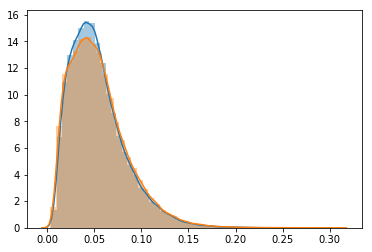

In [100]:
test_preds= 0.5*test_preds1 + 0.5*test_preds2
sns.distplot(y_preds_lgb)
sns.distplot(test_preds)

In [101]:
sub = data_all.loc[data_all.flag1 == "test", ["session_id"]]
sub["is_click"] = test_preds
sub.to_csv("sub_model10.csv", index=False)

print(sub.shape)
sub.head()

(128858, 2)


,session_id,is_click
1,408228,0.092131
5,538081,0.037296
26,551065,0.036824
27,486226,0.043488
28,63570,0.042786


In [103]:
#from sklearn.ensemble import ExtraTreesClassifier
#model = ExtraTreesClassifier(n_estimators=300, min_samples_leaf=250, min_samples_split=400, max_features=0.2, 
#                             random_state=12345786, n_jobs=-1)

#model.fit(X_tr, y_tr,
          #eval_set=[(X_tr, y_tr), (X_val, y_val)],
          #eval_metric='auc',
          #early_stopping_rounds=500,
         # verbose=50
#         )
#y_preds_etr = model.predict_proba(X_val)[:, 1]
#roc_auc_score(y_val, y_preds_etr)

In [104]:
#roc_auc_score(y_val, y_preds_etr*0.05 + y_preds_lgb*0.95)

In [105]:
#curr_score = 0.644853 
#for f in feats:
#    feats2 = [col for col in feats if col != f]
#    X_tr, X_val = tr[feats2], val[feats2]
    #means = X_tr.fillna(-999)
#    X_tr = X_tr.fillna(-1)
#    X_val = X_val.fillna(-1)

#    model = lgb.LGBMClassifier(**lgb_params)
#    model.fit(X_tr, y_tr,
#              eval_set=[(X_tr, y_tr), (X_val, y_val)],
#              eval_metric='auc',
#              early_stopping_rounds=500,
#              verbose=50)
#    y_preds = model.predict_proba(X_val)[:, 1]
#    score = roc_auc_score(y_val, y_preds)
#    if score > curr_score:
#        print(f"IMPROVED ===> Score after removing {f} is {score}")
#        print("-------------")
#    else:
#        print(f"Score after removing {f} is {score}")
#        print("-------------")


In [106]:
#fig, ax = plt.subplots(figsize=(16,16))
#sns.heatmap(tr[feats].corr(), ax=ax)

In [107]:
#for f in feats:
#    _, _, iv = woe(val[f], y_val)
#    if iv < 0.005:
#        print(f"IV value for {f} is {iv} - DISCARD THIS")
#        print("------")
#    else:
#        print(f"=====IV value for {f} is {iv}=====")
#        print("------")

In [108]:
#for f in feats:
#    sns.distplot(data_all.loc[data_all.flag1 == "train", f].fillna(-1))
#    sns.distplot(data_all.loc[data_all.flag1 == "test", f].fillna(-1))
#    plt.show()

In [116]:
data_all.to_csv("data/data_all.csv", index=False)